# Lab 6:

Review the lab material and go through the entire notebook.
The lab contains 5 exercises for you to solve. The entire lab is worth 2.5% of your final grade and each exercise is worth 0.4% of your final grade. Going through the full notebook is worth 0.5% of your final grade.
Any extra credit or bonus exercises are worth an additional 0.4%.

Labs are due by Friday at 11:59 PM PST and can be submitted on BCourses assignment page for the corresponding lab.

## Setup

Run the below steps at the beginning of lab to set up required packages.

In [2]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 40.4 MB/s eta 0:00:00


In [3]:
import itertools
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib as mpl
import matplotlib.pyplot as plt
import rdkit
import seaborn as sns
import urllib.request

from pathlib import Path
from rdkit import Chem, DataStructs
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem import AllChem, Draw, Descriptors
from scipy.spatial import distance
from scipy import stats
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.preprocessing import StandardScaler

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

colors = ["#A20025", "#6C8EBF"]
sns.set_palette(sns.color_palette(colors))

# Ligand-based Screening: Machine Learning

In the first lab, we learned about compound filters and similarity searching in the context of ligand-based virtual screening. In this lab, we will review one way that ML fits into our virtual screening pipeline. The key stages in our workflow are:
1.	Problem definition: Understand what the problem is, what success looks like, and decide if machine learning is the right solution.
2.	Data acquisition: Gather and clean data relevant to the given problem.
3.	Data exploration: Understand the data by visualizing basic attributes.
4.	Pre-processing: Convert our data into a canonical form.
5.	Featurization: Select relevant features from the dataset and transform the data into a suitable input format for our machine learning models. Features represent the individual properties or characteristics of each data point. Synonyms include attribute or descriptor.
6.	Model training: Select a model and train it. Training is the process whereby our model learns a mapping from the features of our training instances to their labels. Synonyms include estimating, fitting, or learning.
a.	Training instance: An individual data point in our training set. Synonyms include observation, record, or sample.
b.	Labels: The property of a data point that we are interested in modeling. Synonyms include outcome, output, response, and target.
7.	Model evaluation: Evaluate and compare our model(s), analyze errors, and iterate as necessary.
8.	Model deployment: Deploy the best model for use in a production environment where it needs to make predictions on new and unseen data, regularly.
9.	Model maintenance: Monitor performance of the deployed model to detect and correct issues.
10.	 Industry assessment: Reassess whether the model achieves its desired business objective and, if not, reinitiate project scoping or consider alternatives.

In practice, the workflow is often iterative and involves returning to previous steps to iterate on prior decisions. It is common to evaluate a model and, based on lack of performance, revisit choices made at the pre-processing, featurization, and model training steps. Another common occurrence is that our model performs well on our existing data but does not accomplish business objectives while in production, requiring us to rethink the problem definition or pivot to new use cases. A third case is that we acquire or generate new data, which guides us back through the subsequent steps with more insight. Note that these are just three examples, and we may go back-and-forth between any stage in the machine learning workflow.

# Problem Understanding

In lab 1, we identified hits with high similarity to one or more Malaria Box compounds. Our next task will be to develop a ligand-based virtual screening model to identify hits that pose cardiotoxic risk. Our model is just one component of a much bigger virtual screening pipeline. A perfectly accurate model will be useless if it doesn’t fulfill the company’s expected use cases and end goal, which leads us to the first question we need to ask: what are the project requirements, constraints, and goals?

As input, we will use our file containing compounds that have high similarity to at least one of the Malaria Box compounds. Though these compounds are promising hits, we want to further filter out any compounds that are active to a cardiotoxicity antitarget. An antitarget (or off-target) is a receptor, enzyme, or other biological target that, when affected by a drug, causes undesirable side-effects. Whereas we want to identify compounds that are active against a target, we want to remove compounds that are active against an antitarget. Antitargets are commonly biomolecules that play important roles in normal physiological processes that are not directly related to the condition that we want to treat.

The antitarget we’ll consider is the human ether-a-go-go-related gene (hERG) potassium channel. Drug-induced blockage of the hERG channel is considered the primary cause of cardiotoxicity and must be screened for early in the drug discovery process. The expected output of your model is binary – the compound does not block the hERG channel and should be kept or it does block the hERG channel and should be removed. Furthermore, the company cares about two failure cases: (1) we miss a cardiotoxic compound that proceeds through the pipeline to clinical trials and fails (incurring cost and damaging brand reputation) and (2) we incorrectly classify an otherwise therapeutically beneficial compound as cardiotoxic and cut its candidacy short.

Coming to a second question to consider, how will we benchmark the success of our model? We could compare our model’s performance against other known models, as well as methods that don’t involve ML, such as rule-based filters to detect HERG blockage by proxy. For instance, blockage of the hERG channel is associated with long QT syndrome, which is a heart disorder that can cause arrhythmia (fast, rapid heartbeats). To estimate hERG blockage, we might construct a small set of structural alerts that are associated with arrhythmia endpoints. If a compound contains several structural alerts greater than a user-defined threshold of these structures, it is filtered out.


## Our Machine Learning Task

Where to begin? What ML model to use? Why do we expect an ML model to be better than a simple rule-based approach like structural alerts? Furthermore, suppose we did know the target’s structure. Why might we still think that machine learning can add value, rather than moving directly to a structure-based method? There are a few guiding principles for assessing when machine learning may be of value:
1.	Existing data is available or can be collected.
2.	The data contains complex patterns, and our model has the capacity to learn how those patterns correspond to known outcomes. Here, capacity refers to the model’s ability to learn a variety of possible functions, where greater model complexity implies greater capacity in learning.
3.	We have enough data that important patterns may be repeated multiple times, making it easier for the model to remember them.
4.	Our model can solve problems by using what it has learned to make predictions on new data, assuming that the new data is similar to the model’s training data.
5.	Our model can be applied to new data at scale and speed that is not possible with current solutions.

Our task is a typical classification task: the model needs to output which class each compound belongs. A compound belongs to either the positive class if hERG blocking or negative class if not. Since there are only two classes to predict, this is a binary classification task. If we were trying to predict more than two possible classes, it would be a multiclass classification problem. In general, binary classification is easier than multiclass classification. Lastly, we can train a model using a labeled dataset of compounds known to either block or not block the hERG channel, which makes this a supervised learning task.


## Data Acquisition, Exploration, & Curation

There are many public databases such as PubChem and ChEMBL with existing data for molecular property prediction. Another valuable source of data are publications that make the data used in their experiments publicly available. If you are already familiar with a specific subfield in cheminformatics, then you likely know of common benchmark datasets derived from individual publications. If you are not familiar with a field and what dataset publications exist, it is helpful to reference a dataset aggregator. For example, Papers With Code open sources datasets across a variety of machine learning fields and tasks, including some pertaining to drug discovery. Another collection specifically for drug discovery is aggregated by Therapeutics Data Commons (TDC).

### Loading and Exploring the hERG Blockers Dataset

If we navigate to TDC datasets for toxicity, we can find references for three datasets related to hERG blockers. For ease of use, let’s start off with downloading and loading the “hERG blockers” dataset into a Pandas data frame.


In [5]:
herg_blockers_path = Path("data/hERG_blockers.xlsx")

herg_blockers = pd.read_excel(
      herg_blockers_path,
      usecols="A:F",
      header=None,
      skiprows=[0,1,],
      names=["SMILES", "Name", "pIC50", "Class", "Scaffold Split", "Random Split"],
    ).head(-68)


We can peek at the top three rows via herg_blockers.head(3)

In [6]:
herg_blockers.head(3)

,SMILES,Name,pIC50,Class,Scaffold Split,Random Split
0,Fc1ccc(cc1)Cn1c2c(nc1NC1CCN(CC1)CCc1ccc(O)cc1)...,DEMETHYLASTEMIZOLE,9.00000,1,Training I,Training II
1,Fc1ccc(cc1)C(OCC[NH+]1CC[NH+](CC1)CCCc1ccccc1)...,GBR-12909,9.00000,1,Training I,Training II
2,O=[N+]([O-])c1ccc(cc1)CCCCN(CCCCCCC)CC,LY-97241,8.79588,1,Training I,Training II


Let’s take a quick look at the non-null count and data type of each column:

In [7]:
herg_blockers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SMILES          587 non-null    object 
 1   Name            565 non-null    object 
 2   pIC50           526 non-null    float64
 3   Class           587 non-null    int64  
 4   Scaffold Split  587 non-null    object 
 5   Random Split    587 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 27.6+ KB


The hERG blockers data is a set of 587 compounds. Each row represents one compound. There are six columns:
- Name: The name of the compound.
- SMILES: Textual representation of each compound’s structure.
- pIC50: Higher pIC50 indicates greater drug potency. pIC50 is derived from IC50, an experimental measure of the concentration of a drug at which it inhibits a specific biological process by 50%. The “IC” stands for inhibitory concentration. Reported IC50 values can have a large range and different units. To standardize comparison, IC50 is often converted to pIC50. pIC50 is the negative of the log of the IC50 in molar (M). Molar (M) is a measurement of the concentration of a chemical species. For example:
  - An IC50 of 1 nM is 10-9 M, which is a pIC50 of 9.0. An IC50 of 1 µM is 10-6 M, which is a pIC50 of 6.0.
  - This attribute is null for several compounds, but we can’t use this attribute for training and it did not affect the number of non-null class attributes that we will use for labels.
- Class: Each drug is labeled with a “1” if it blocks the hERG channel and a “0” if it does not block the hERG channel. This is the column that we want to train a model to be able to predict. The authors used a threshold of 〖"IC" 〗_50<40 μM to define drugs as hERG blockers. This threshold corresponds to a pIC50 > 4.4.
- Set I: The authors split the dataset into training and test data using a scaffold split. We won’t use the set I column.
- Set II: The authors split the dataset into training and test data using a random split. We will use the set II column to define our training and test data.

There is a clear demarcation between the compound classes based on pIC50. However, we can’t use the pIC50 column as a feature for model training as pIC50 was used to define the class variable we are predicting. Furthermore, we may not want to rely on pIC50 measurements as it requires experimental data, which may be costly, and pIC50 data quality may vary due to missing values or inconsistent experiment conditions or readouts. Furthermore, pIC50 is experimentally derived. The purpose of our model is to predict whether a compound is a hERG blocker or not prior to conducting an experiment.

Regardless of whether the data comes from a large, well-established public or commercial database or a small dataset in literature, curation is always necessary to mitigate possible mistakes in the dataset. Manually reviewing all dataset entries is not feasible and even a random selection of a small subset, while useful, might miss problematic entries. Instead, we can harness exploratory data analysis (EDA) to plot and summarize features of the data. EDA helps us understand the range of molecular properties that the data covers and can be used to spot inconsistencies.


Let’s get familiar with our data by plotting the distribution of pIC50 values. On the left is the distribution of pIC50 values for the real hERG blockers dataset. On the right is the distribution of pIC50 values for hERG blockers dataset with simulated curation error.

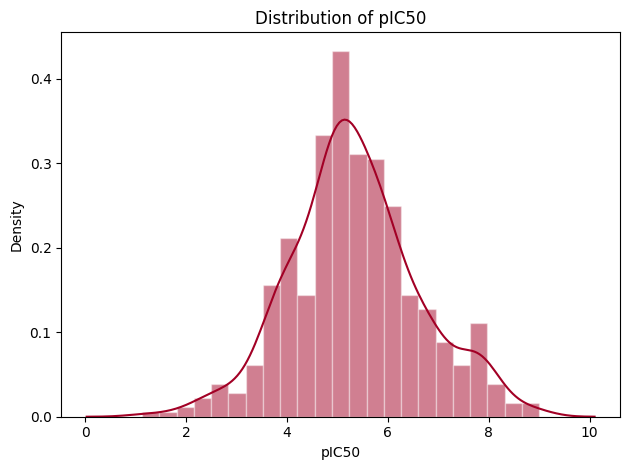

In [8]:
sns.histplot(
    herg_blockers["pIC50"], kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
)
plt.title("Distribution of pIC50")
plt.tight_layout()


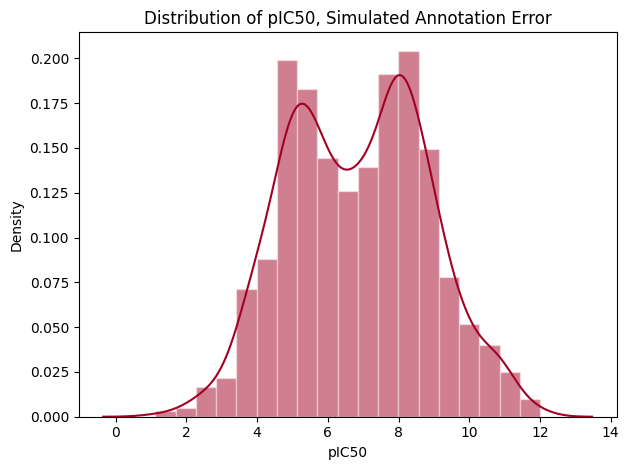

In [9]:
simulated_error = herg_blockers["pIC50"] + 3.0
sns.histplot(
    herg_blockers["pIC50"]._append(simulated_error, ignore_index=True), kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4),
)
plt.title("Distribution of pIC50, Simulated Annotation Error")
plt.tight_layout();

Reviewing the distribution of continuous variables can be useful to ensure that the range of values falls within what we would expect. Even though we won’t use pIC50 values for modeling, it’s possible that there were annotation errors when logging the experimental pIC50 values. For example, if the distribution of pIC50 values followed a bimodal distribution 3 units apart as shown in the right side of the previous plot, then we may want to dive deeper into what could be a potential data curation issue (i.e., the annotator used units of nanomolar instead of micromolar).

### Validating & Standardizing SMILES

Let’s visualize a few of the drugs in this dataset, both to understand the diversity in structure across blockers and non-blockers and to get a feel for how SMILES corresponds to the actual drug structure. In addition, this can help us to spot errors in drug structure that are more likely at extremes of the data.

After running the following code block, you'' see a figure where the top row displays the structures of the compounds with highest experimentally measured pIC50. The bottom row displays the structures of the compounds with lowest experimentally measured pIC50.

In [10]:
from rdkit.Chem import Draw
d2d = Draw.MolDraw2DSVG(-1, -1)
dopts = d2d.drawOptions()
dopts.useBWAtomPalette()
dopts.setHighlightColour((.635,.0,.145,.4))
dopts.additionalAtomLabelPadding = 0.15

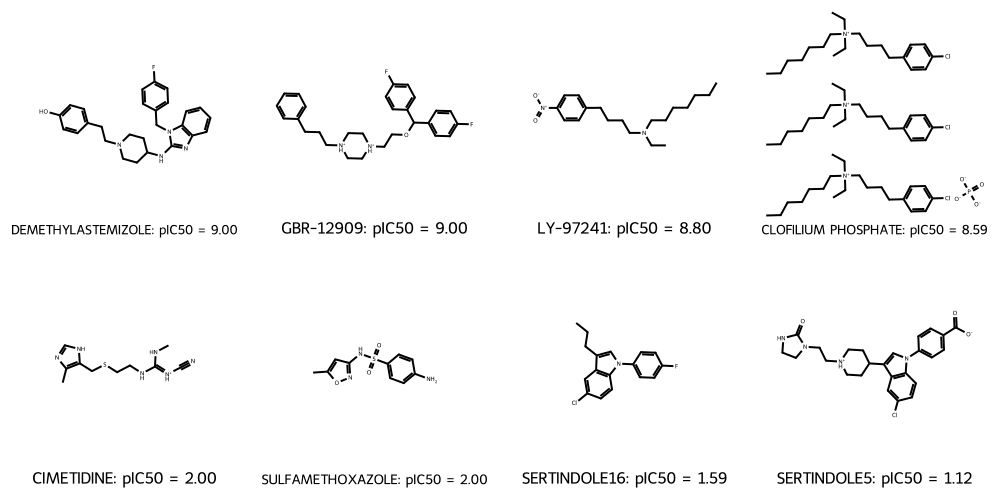

In [11]:
extremes = pd.concat([herg_blockers[:4], herg_blockers.dropna()[-4:]])
legend_text = [
    f"{x.Name}: pIC50 = {x.pIC50:.2f}" for x in extremes.itertuples()
]
extreme_mols = [rdkit.Chem.MolFromSmiles(smi) for smi in extremes.SMILES]
img = Draw.MolsToGridImage(
    extreme_mols, molsPerRow=4, subImgSize=(250, 250), legends=legend_text, useSVG=True, drawOptions=dopts,
)
img


From the previous figure, we can see some shared structural patterns between LY-97241 and clofilium phosphate, which are hERG blockers, and between sertindole16 and sertindole5, which are not hERG blockers. If we were to review more of the compounds, we’d see that these structural patterns can be complex but could be exploited by ML. We posit that our ML model can learn an optimal function for detecting structural patterns linked to hERG blockage, rather than us retrospectively determining structural alerts from manual inspection.

Inspection at the extremes is also more likely to catch outliers or mistakes. Should clofilium phosphate have repeated structures or is that a mistake? Should GBR-12909 be charged considering that other references to its structure in literature report the structure as uncharged?
To address these problems, we standardize the data.

Standardized data allows for meaningful comparisons between different experiments or studies that aid in reproducibility of experiments, sharing data collected from various sources, and dissemination of results. In contrast to molecular validation, molecular standardization modifies the compounds with a set of standard operations that align the representations of all compounds in our dataset.

We will use a standardization pipeline that chains the following processes supported within RDKit’s rdMolStandardize module.
1.	Disconnect metal atoms that are covalently bonded to non-metal atoms.
2.	Normalize the molecules to cleanup functional groups.
3.	Assign stereochemistry and remove redundant chirality specifications.
4.	Remove salts, solvents, and other fragments, retaining the largest parent fragment.
5.	Neutralize the molecule by adding or removing hydrogens where possible.
6.	Enumerate all possible tautomers, score them, and retain a canonical tautomer based on the assigned scores (e.g., the most stable tautomer).



In [12]:
from rdkit.Chem.MolStandardize.rdMolStandardize import (
    Cleanup,
    LargestFragmentChooser,
    TautomerEnumerator,
    Uncharger
)

def process_smiles(smi):
  mol = rdkit.Chem.MolFromSmiles(smi)
  mol = Cleanup(mol)
  mol = LargestFragmentChooser().choose(mol)
  mol = Uncharger().uncharge(mol)

  return TautomerEnumerator().Canonicalize(mol)

herg_blockers["mol"] = herg_blockers["SMILES"].apply(process_smiles)

[04:24:08] Initializing MetalDisconnector
[04:24:08] Running MetalDisconnector
[04:24:08] Initializing Normalizer
[04:24:08] Running Normalizer
[04:24:08] Running LargestFragmentChooser
[04:24:08] Running Uncharger
[04:24:08] Initializing MetalDisconnector
[04:24:08] Running MetalDisconnector
[04:24:08] Initializing Normalizer
[04:24:08] Running Normalizer
[04:24:08] Running LargestFragmentChooser
[04:24:08] Running Uncharger
[04:24:08] Removed positive charge.
[04:24:08] Removed positive charge.
[04:24:08] Initializing MetalDisconnector
[04:24:08] Running MetalDisconnector
[04:24:08] Initializing Normalizer
[04:24:08] Running Normalizer
[04:24:08] Running LargestFragmentChooser
[04:24:08] Running Uncharger
[04:24:08] Initializing MetalDisconnector
[04:24:08] Running MetalDisconnector
[04:24:08] Initializing Normalizer
[04:24:08] Running Normalizer
[04:24:08] Running LargestFragmentChooser
[04:24:08] Fragment: CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1
[04:24:08] New largest fragment: CCCCCCC

After standardization, GBR-12909 has been neutralized and clofilium phosphate has had excess fragments removed. Our next step will be to represent the dataset as fingerprints, which doesn’t make sense for entries that would be more than one fragment.

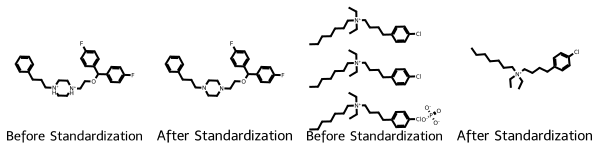

In [13]:
before_and_after_mols = [rdkit.Chem.MolFromSmiles(herg_blockers.iloc[1].SMILES), herg_blockers.iloc[1].mol, rdkit.Chem.MolFromSmiles(herg_blockers.iloc[3].SMILES), herg_blockers.iloc[3].mol]
legend_text = ["Before Standardization", "After Standardization"] * 2
img = Draw.MolsToGridImage(
    before_and_after_mols, molsPerRow=4, subImgSize=(150, 150), legends=legend_text, useSVG=True, drawOptions=dopts,
)
img

### Feature Generation & Exploration

Now that we have standardized our data set to a consistent format, we’ll compute 2048-dimensional representations of the 587 molecules using Morgan fingerprints. Once we’ve represented our data in terms of fingerprints, we can begin to visualize the distribution of the bits set across all fingerprints to try and understand more about the diversity of structures that might be represented.

In [14]:
def compute_fingerprint(mol: rdkit.Chem.Mol, r: int, nBits: int) -> np.ndarray:
    """Featurize Rdkit Mol into Morgan Fingerprint bit vectors.

     Args:
         mol: an Rdkit Mol object (representing a molecule).

     Returns:
         numpy.ndarray: A 1-D numpy array of the featurized molecule.
    """
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, r, nBits=nBits)
    arr = np.zeros((1,), dtype=np.int8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

fingerprints = np.stack([compute_fingerprint(mol, 2, 2048) for mol in herg_blockers.mol])
fingerprints.shape

[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerator
[04:27:17] DEPRECATION WARNING: please use MorganGenerat

(587, 2048)

Our hERG blockers dataset contains new fingerprint descriptors that we can analyze prior to modeling. In the left figure produced by the following code block, the data’s fingerprint representation is sparse, though there is noticeable fluctuation in the frequency at which some bits are set, and the number of bits set by each molecule. Most bits are set by 30 or less molecules out of the possible 587 compounds. However, we can see several outlier bits that are set by hundreds of compounds. These outlier bits likely correspond to common structures present in most of the compounds in our data.

The right gives a clearer picture of the distribution of bits set per molecule. Each compound typically sets a spread of 40 to 60 bits. At the extremes, there are compounds with as little as approximately 10 bits set as well as compounds that max out at 100 bits set out of the possible 2048 bits.

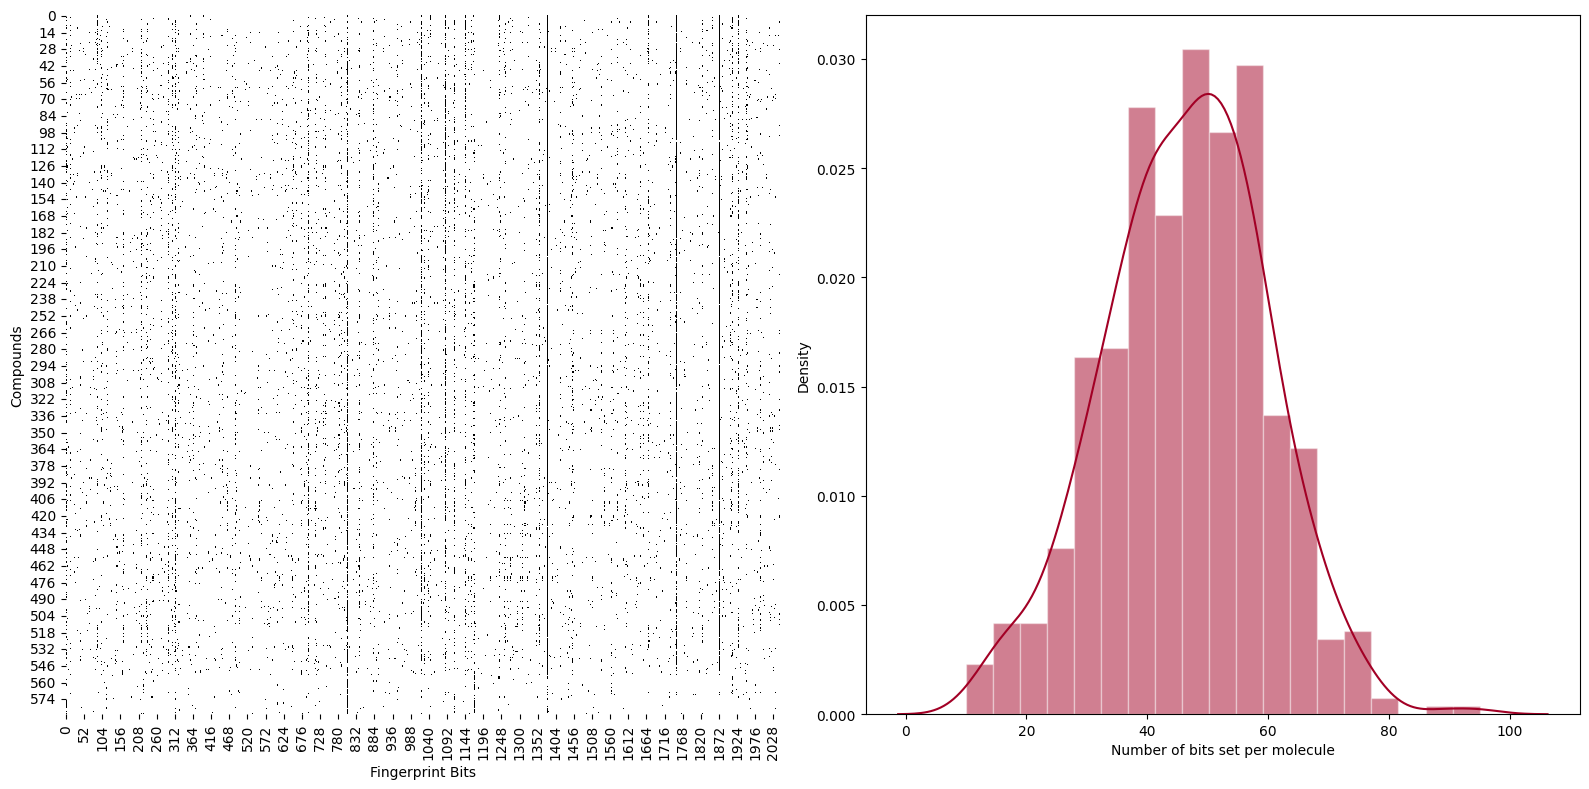

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
sns.heatmap(fingerprints, cbar=False, cmap=plt.cm.Greys, ax=ax[0])
ax[0].set_xlabel("Fingerprint Bits")
ax[0].set_ylabel("Compounds")

sns.histplot(
    fingerprints.sum(axis=1), kde=True,
    stat="density", kde_kws=dict(cut=3),
    edgecolor=(1, 1, 1, .4), ax=ax[1]
)
ax[1].set_xlabel("Number of bits set per molecule")
fig.tight_layout();

With fingerprints to provide a numerical representation of each molecule, we can begin thinking about how we can leverage this representation for a machine learning model to establish a relationship between fingerprint bits and their influence on hERG blocking predisposition.

# Application of Linear Models

We now enter what is typically viewed as the “fun” part of our ML workflow – modeling. During training, our ML model ingests data encoded as features and learns how to map those features to the property we want to predict. Before we train our linear model, we’ll formalize what we want our model to achieve and how to do so via the data available to it.

## Learning from Data

A medicinal chemist might be able to look at a chemical compound and recognize whether it contains certain substructures that are likely to cause hERG blockage. How do we get a computer to do the same? We leverage extensive, historical data on past compounds, which are labeled to indicate whether they were positive or negative for hERG blockage according to previous experiments. This labeled data set forms the basis of what our linear, supervised model will learn from.

### Data Generating Distribution

We can formally define our problem as a mathematical function, f∶ X→Y, that maps the set of all possible inputs, X, to the set of all possible outputs, Y. In this case, the set of all possible inputs is the full chemical space of druglike compounds, and the set of all possible outputs is a simple “yes” or “no” determination about whether an input compound will be hERG blocking. Each individual compound, $x$, is represented with feature information that might aid in predicting whether it has “anti-cancer” behavior. Our data set contains pairs of input-output examples $(x_1,y_1 ),…,(x_N,y_N )$, where each $y_n$ for $n=1,…,N$ is the output of feeding its corresponding input, $x_n$, into $f$.

The function f represents the solution to our problem, and we refer to it as the target function. The target function represents ground truth. If we have f, then we can determine whether any co wouldn’t need to train a model to begin with!

Sadly, f is unknown to us and we must try to approximate the entire function from the few instances that make up our training data set. We train a model that maps our inputs to a predicted output. Ideally, our trained model results in correct predictions on our training data set of historical compound behavior, while generalizing to new compounds that we don’t have any training samples for and that the model has never encountered.

The following figure shows how this can be a leap of faith – the training data set represents a sampled snapshot of the entire space of drug-like chemical compounds. Depending on how the data was sourced, the subset of the chemical space that our model is exposed to could vary drastically. We hope that our trained model is correct where we don’t have training samples and that the distribution of the training set approximates the ground truth distribution of the target function. The more data available to us, the more likely that both assumptions will hold and that we can achieve a performative model.

![UN01](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L06_UN01_Flynn.png?raw=1)

In reference to the figure, the target function represents ground truth. It is an unknown function that maps input data to their corresponding target or label values. The difficulty is that we must learn the entire function from a few training instances. We will estimate model weights that “fit” the training points exactly, assuming that the resulting function is correct where we don’t have training instances. We also assume that the distribution of sampled data that constitutes our training set is equivalent to the target function’s distribution. The more data available to us, the more likely that both assumptions will hold.

### The Learning Algorithm

The question remains: how do we use the data available to us to train a model? For simplicity, we’ll consider only parametric models.

During training, our ML model ingests training data encoded as features and learns how to map those features to the property we want to predict. Our model is governed by a set of weights (or parameters). Weights are real numbers that express the importance of the model’s inputs to its output. The model’s weights govern how the model maps input features to output predictions. The value of each weight influences the model’s predictions and, consequently, its performance. The model’s performance evaluates the quality of its predictions. If the predictions are bad, which they likely will be at the beginning, then our model requires a mechanism to learn from experience, alter its weights, and improve its performance.

Learning algorithms enable automatic tuning of model weights based on performance. The learning process involves optimizing parametric model weights to achieve accurate predictions on both the training data and on new, unseen data. Each possible combination of weight values represents a separate hypothesis function. When we train our model, the model iteratively adjusts the values of these weights as it learns to recognize patterns in the data at different levels of abstraction.

With each iteration of training, the learning algorithm helps the model adjust its weights in the direction that improves performance on our training dataset. Each learning algorithm consists of three components:
1.	A loss function, or error function. The loss function measures the error between the predicted output and the actual label or ground truth class. It represents a penalty for the model’s prediction error on a single data instance.
2.	An optimization function based on the loss function. Cost functions are a type of objective function commonly used in ML learning algorithms. The cost function measures an aggregate error term for the model’s predictions across all data instances. For example, it could be the average of the loss functions across the full training set. With cost functions, lower is better.
3.	A learning routine that guides weight adjustments to minimize the cost function (in general terms, to optimize the optimization function).

As visualized in the following figure, our ML model learns a function that maps each input data instance to a prediction about a property of interest. The loss and optimization functions measure and aggregate the performance of the model’s predictions. In tandem with a learning routine, the model’s weights are updated such that, in the next iteration of training, the model will reduce its previous error and perform better.

![UN02](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L06_UN02_Flynn.png?raw=1)

Once we have chosen our final, trained model, we no longer incorporate weight updates. The weights are frozen and are now inherent to the model. During inference, the model simply acts on new data to generate predictions.

![UN03](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L06_UN03_Flynn.png?raw=1)


## Training our Linear Model

Intuitively, our model acts as a function that maps molecule structure, encoded as fingerprints, to a property of interest. We’ll train a linear classifier to learn the correspondence between fingerprints and ability to block the hERG channel.

The following figure generalizes the process to any ML classifier. We can view our ML model as a function that learns correspondence between the structures in the input data and the output property we are modeling. To mediate this, we convert the molecule into fingerprint features that quantify its structure.

![UN04](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L06_UN04_Flynn.png?raw=1)

The next figure depicts a simplified form of the output that our model will produce given molecule inputs, as represented by descriptors or fingerprints. (Left) Initially, our untrained model misclassifies multiple instances. The model’s decision boundary will adjust with each training iteration. (Right) Our ML model can learn a decision boundary that partitions the input data into “hERG blocker” and “not hERG blocker” classes. Assuming our data is linearly separable with respect to hERG blocker classes, we hope to develop a linear model whose decision boundary correctly separates the training data and generalizes to new data that wasn’t in the training set.

![UN05](https://github.com/nrflynn2/swe-molecular-sciences/blob/main/figures/L06_UN05_Flynn.png?raw=1)

The hERG blockers dataset has a pre-defined random split that partitions 392 instances into a training set and 195 instances into a test set. After we split the data, we can use the training data set to train a classifier, with many approaches available to frame this problem (see Scikit-Learn’s documentation on linear models for more ideas). We’ll demonstrate the use of Scikit-Learn’s SGDClassifier to tackle this problem.

Note: Ignore the deprecation warning that arises during fingerprint generation.

In [16]:
from sklearn.linear_model import SGDClassifier

def split_data(df, split_col="Random Split"):
  train_indices = df.index[df[split_col].str.contains("Train")].tolist()
  test_indices = df.index[df[split_col].str.contains("Test")].tolist()
  return (
    df.iloc[train_indices].sample(frac=1).reset_index(drop=True),
    df.iloc[test_indices].sample(frac=1).reset_index(drop=True)
  )

train_set, test_set = split_data(herg_blockers)
train_fingerprints = np.stack([compute_fingerprint(mol, 2, 2048) for mol in train_set.mol])
train_labels = train_set.Class

lin_cls = SGDClassifier()
lin_cls.fit(train_fingerprints, train_labels)

[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerator
[06:53:55] DEPRECATION WARNING: please use MorganGenerat

SGDClassifier()

Great, now we have a trained linear classifier. We can use it to generate predictions and also assess how good the model performs. The simplest metric for evaluating binary classifier performance is accuracy. Let’s see how well our model fits to the training set.

In [17]:
herg_blockers_predictions = lin_cls.predict(train_fingerprints)
herg_blockers_predictions[:10]

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [18]:
train_labels.iloc[:10].values

array([1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

In [19]:
from sklearn.metrics import accuracy_score
accuracy_score(train_labels, herg_blockers_predictions)

0.9617346938775511

Wow! Our linear classifier is correct 96.2% of the time! Did we just solve the hERG blocker prediction challenge? Not quite.

For us to judge our model as successful, it needs to perform well not only on data within the training set, but also generalize to unseen data. The following code retrains our model on five different train/test splits and then averages the accuracy of each trained model on its corresponding test split, producing a more realistic view of its performance.

In [20]:
from sklearn.model_selection import cross_validate

scoring = {'acc': 'accuracy'}
lin_cls_scores = cross_validate(lin_cls, train_fingerprints, train_labels, scoring=scoring, cv=5)
lin_cls_scores["test_acc"].mean()

np.float64(0.7756247971437845)

We’ve been using accuracy, but this is not the preferred metric for classifiers. It is especially problematic for a data set such as ours, where there are over twice as many positive class instances as there are negative class instances. We could create a naïve baseline that just classifies everything as the most frequent class. If we evaluate such a dummy classifier that classifies all instances as hERG blockers, we can achieve almost 70% accuracy! This is because 70% of the compounds in our data set are hERG blockers.

In [21]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(train_fingerprints, train_labels)
accuracy_score(train_labels, dummy_clf.predict(train_fingerprints))

0.6938775510204082

The following code block furter illustrates the discrepancy in possible classification metrics between the train and validaton/test sets.

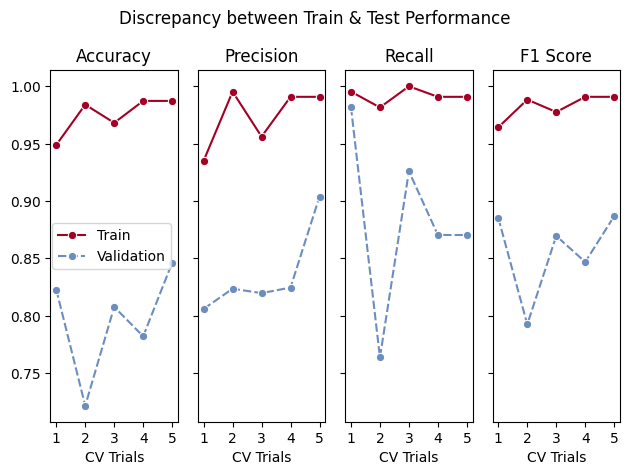

In [22]:
scoring = {
  'acc': 'accuracy',
  'prec_macro': 'precision',
  'rec_macro': 'recall',
  'f1_macro': 'f1',
}
lin_cls_scores = cross_validate(lin_cls, train_fingerprints, train_labels, scoring=scoring, cv=5, return_train_score=True)
lin_cls_scores_df = pd.DataFrame.from_dict(lin_cls_scores)
lin_cls_scores_df.describe().round(3)

fig, axes =plt.subplots(1, 4, sharey=True)
fig.suptitle("Discrepancy between Train & Test Performance")

sns.lineplot(ax=axes[0], data=[lin_cls_scores_df["train_acc"], lin_cls_scores_df["test_acc"]], marker="o")
axes[0].set_xticks(range(len(lin_cls_scores_df)))
axes[0].set_xticklabels([1, 2, 3, 4, 5])
axes[0].set_title("Accuracy")
axes[0].set_xlabel("CV Trials")

sns.lineplot(ax=axes[1], data=[lin_cls_scores_df["train_prec_macro"], lin_cls_scores_df["test_prec_macro"]], legend=False, marker="o")
axes[1].set_xticks(range(len(lin_cls_scores_df)))
axes[1].set_xticklabels([1, 2, 3, 4, 5])
axes[1].set_title("Precision")
axes[1].set_xlabel("CV Trials")

sns.lineplot(ax=axes[2], data=[lin_cls_scores_df["train_rec_macro"], lin_cls_scores_df["test_rec_macro"]], legend=False, marker="o")
axes[2].set_xticks(range(len(lin_cls_scores_df)))
axes[2].set_xticklabels([1, 2, 3, 4, 5])
axes[2].set_title("Recall")
axes[2].set_xlabel("CV Trials")

sns.lineplot(ax=axes[3], data=[lin_cls_scores_df["train_f1_macro"], lin_cls_scores_df["test_f1_macro"]], legend=False, marker="o")
axes[3].set_xticks(range(len(lin_cls_scores_df)))
axes[3].set_xticklabels([1, 2, 3, 4, 5])
axes[3].set_title("F1 Score")
axes[3].set_xlabel("CV Trials")

fig.tight_layout()
axes[0].legend(handles=axes[0].get_legend_handles_labels()[0], labels=["Train", "Validation"])

So, in practice, we would still have a lot of work to do to develop a better model! The following exercises walk through your understanding of the material in this lab and ability to search external sources and think of ways to improve what we've done.

# Exercises

## Exercise 1

Read the following article on precision and recall as metrics for evaluating a machine learning classifier: https://mlu-explain.github.io/precision-recall/

What is a true positive, true negative, false positive, and false negative? Given these terms, what are the equations for computing precision and recall?

Answer to Exercise 1:
True positive is when a positive instance is correctly determined to be positive. True negative is when a negative instance is correctly determined to be negative. False positive is when a negative instance is incorrectly determined to be positive. False negative is when an positive instance is incorrectly determined to be negative. To compute precision, true positive is divided by the sum of true positive and false positive. To compute recall, true positive is divided by the sum of true positive and false negative.

## Exercise 2

Consider the tradeoff plot near the end of the article. As the decision boundary threshold increases, what happens to the recall? What happens to the precision? Are either recall or precision monotonically increasing or decreasing metrics?

Answer to Exercise 2: Recall decreases as the decision boundary threshold increases. Precision increases as the decision boundary threshold increases. Recall is monotonically decreasing metrics while precision is not monotonically increasing metrics, because precision seems to show decreasing metrics at some decision boundary threshold, even thought precision generally increases as the decision boundary threshold increases.

## Exercise 3

Why did we standardize the hERG blockers data set as a preprocessing step before featurizing and training stages?

Standardization ensures data across different experiments or studies have the same set of standard operations and are comparable. The benefits are experimental reproducibility, improve data sharing and results dissemination.

## Exercise 4

What is one idea you have to improve our performance? For example, could we use different features and, if so, which ones? Could we use a different mode and, if so, which one? Do you think we could incorporate any additional data sources and, if so, from where?

Molecules represented as graph neural network could be used as features to feed into the model and compare the predictions to experimental results. Over time, the model has many datasets to learn from, and the loss function in the model could help adjust the weights of the features which eventually improves the performance of the model.

## Exercise 5

Which lab was your favorite and why? Which lab was your least favorite and do you think it could be improved to be more useful or do you think that nothing could be done to salvage it (beyond swapping it with an entirely different lab)?

Lab 2 Traversals on Drug Metabolism Networks was my favorite because I got to learn how to code graphs and visualize graphs. I think I was able to learn many technical tools from Lab 2. Lab 4 Becoming Dangerous with SQL was my least favorite. Even though I learned many technical tools, the lab was a bit lengthy and wordy which made it difficult to focus on key concepts in the allotted time.